In [49]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [50]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [51]:
train_df.drop(labels=['keyword','location','id'],axis=1,inplace=True)
test_df.drop(labels=['keyword','location','id'],axis=1,inplace=True)

In [52]:
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [53]:
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [54]:
train_text = train_df['text']
target = train_df['target']
# train_data = tf.data.Dataset.from_tensor_slices

In [55]:
tfhub_handle_encoder = 'https://tfhub.dev/google/experts/bert/wiki_books/sst2/2'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [56]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [57]:
classifier_model = build_classifier_model()

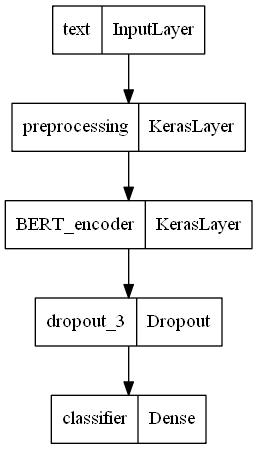

In [58]:
tf.keras.utils.plot_model(classifier_model)

In [59]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [61]:
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(),
                         loss=loss,
                         metrics=metrics)

In [62]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_text,
                               y=target,
                               batch_size=13,
                               validation_split=0.2,
                               epochs=epochs)

Training model with https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Epoch 1/5


ResourceExhaustedError: Graph execution error:

failed to allocate memory
	 [[{{node transformer/layer_4/activation/Gelu/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_255800]